In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
def get_dataset():
    
    prev_dtype = {
        'SK_ID_PREV': np.uint32, 'SK_ID_CURR': np.uint32, 'HOUR_APPR_PROCESS_START': np.int32, 'NFLAG_LAST_APPL_IN_DAY': np.int32,
        'DAYS_DECISION': np.int32, 'SELLERPLACE_AREA': np.int32, 'AMT_ANNUITY': np.float32, 'AMT_APPLICATION': np.float32,
        'AMT_CREDIT': np.float32, 'AMT_DOWN_PAYMENT': np.float32, 'AMT_GOODS_PRICE': np.float32, 'RATE_DOWN_PAYMENT': np.float32,
        'RATE_INTEREST_PRIMARY': np.float32, 'RATE_INTEREST_PRIVILEGED': np.float32, 'CNT_PAYMENT': np.float32,
        'DAYS_FIRST_DRAWING': np.float32, 'DAYS_FIRST_DUE': np.float32, 'DAYS_LAST_DUE_1ST_VERSION': np.float32,
        'DAYS_LAST_DUE': np.float32, 'DAYS_TERMINATION': np.float32, 'NFLAG_INSURED_ON_APPROVAL': np.float32
    }
    
    bureau_dtype = {
        'SK_ID_CURR': np.uint32, 'SK_ID_BUREAU': np.uint32, 'DAYS_CREDIT': np.int32,'CREDIT_DAY_OVERDUE': np.int32,
        'CNT_CREDIT_PROLONG': np.int32, 'DAYS_CREDIT_UPDATE': np.int32, 'DAYS_CREDIT_ENDDATE': np.float32,
        'DAYS_ENDDATE_FACT': np.float32, 'AMT_CREDIT_MAX_OVERDUE': np.float32, 'AMT_CREDIT_SUM': np.float32,
        'AMT_CREDIT_SUM_DEBT': np.float32, 'AMT_CREDIT_SUM_LIMIT': np.float32, 'AMT_CREDIT_SUM_OVERDUE': np.float32,
        'AMT_ANNUITY': np.float32
    }
    
    bureau_bal_dtype = {
        'SK_ID_BUREAU': np.int32, 'MONTHS_BALANCE': np.int32,
    }
    
    pos_dtype = {
        'SK_ID_PREV': np.uint32, 'SK_ID_CURR': np.uint32, 'MONTHS_BALANCE': np.int32, 'SK_DPD': np.int32,
        'SK_DPD_DEF': np.int32, 'CNT_INSTALMENT': np.float32,'CNT_INSTALMENT_FUTURE': np.float32,
    }
    
    install_dtype = {
        'SK_ID_PREV': np.uint32, 'SK_ID_CURR': np.uint32, 'NUM_INSTALMENT_NUMBER': np.int32, 'NUM_INSTALMENT_VERSION': np.float32,
        'DAYS_INSTALMENT': np.float32, 'DAYS_ENTRY_PAYMENT': np.float32, 'AMT_INSTALMENT': np.float32, 'AMT_PAYMENT': np.float32,
    }
    
    card_dtype = {
        'SK_ID_PREV': np.uint32, 'SK_ID_CURR': np.uint32, 'MONTHS_BALANCE': np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL': np.int32, 'CNT_DRAWINGS_CURRENT': np.int32, 'SK_DPD': np.int32,'SK_DPD_DEF': np.int32,
        'AMT_BALANCE': np.float32, 'AMT_DRAWINGS_ATM_CURRENT': np.float32, 'AMT_DRAWINGS_CURRENT': np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT': np.float32, 'AMT_DRAWINGS_POS_CURRENT': np.float32, 'AMT_INST_MIN_REGULARITY': np.float32,
        'AMT_PAYMENT_CURRENT': np.float32, 'AMT_PAYMENT_TOTAL_CURRENT': np.float32, 'AMT_RECEIVABLE_PRINCIPAL': np.float32,
        'AMT_RECIVABLE': np.float32, 'AMT_TOTAL_RECEIVABLE': np.float32, 'CNT_DRAWINGS_ATM_CURRENT': np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT': np.float32, 'CNT_DRAWINGS_POS_CURRENT': np.float32, 'CNT_INSTALMENT_MATURE_CUM': np.float32,
    }
    
    app_train = pd.read_csv('../data/home-credit-default-risk/application_train.csv')
    app_test = pd.read_csv('../data/home-credit-default-risk/application_test.csv')
    apps = pd.concat([app_train, app_test])
    prev = pd.read_csv('../data/home-credit-default-risk/previous_application.csv', dtype=prev_dtype)
    bureau = pd.read_csv('../data/home-credit-default-risk/bureau.csv', dtype=bureau_dtype)
    bureau_balance = pd.read_csv('../data/home-credit-default-risk/bureau_balance.csv', dtype=bureau_bal_dtype)
    pos_bal = pd.read_csv('../data/home-credit-default-risk/POS_CASH_balance.csv', dtype=pos_dtype)
    install = pd.read_csv('../data/home-credit-default-risk/installments_payments.csv', dtype=install_dtype)
    card_bal = pd.read_csv('../data/home-credit-default-risk/credit_card_balance.csv', dtype=card_dtype)
    
    return apps, prev, bureau, bureau_balance, pos_bal, install, card_bal

In [4]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def get_apps_processed(apps):
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY'] / apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE'] / apps['AMT_CREDIT']
    apps['APPS_CREDIT_GOODS_DIFF'] = apps['AMT_CREDIT'] - apps['AMT_GOODS_PRICE']
    
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY'] / apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT'] / apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE'] / apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['CNT_FAM_MEMBERS']
    
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED'] / apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps


def get_prev_processed(prev):
    
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_APPLICATION']
    prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY'] / prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE'] / prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay / prev['AMT_CREDIT'] - 1) / prev['CNT_PAYMENT']
    
    return prev


def get_prev_amt_agg(prev):    

    agg_dict = {
         # 기존 컬럼. 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 가공 컬럼
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }
    
    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)
    prev_amt_agg.columns = ['PREV_' + ('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]
    prev_amt_agg = prev_amt_agg.reset_index()
    
    return prev_amt_agg


def get_prev_refused_appr_agg(prev):

    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT']
    prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
    
    return prev_refused_appr_agg


def get_prev_agg(prev):
    
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT'] / prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT'] / prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg


def get_apps_all_with_prev_agg(apps, prev):

    apps_all = get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all


def get_apps_all_encoded(apps_all):
    
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all


def get_apps_all_train_test(apps_all):

    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]
    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

In [5]:
bureau_agg_dict = {
    'SK_ID_BUREAU': ['count'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],

    'BUREAU_ENDDATE_FACT_DIFF': ['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF': ['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF': ['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO': ['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF': ['min', 'max', 'mean'],
    'BUREAU_IS_DPD': ['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120': ['mean', 'sum'],
}

bureau_bal_agg_dict = {
    'SK_ID_CURR': ['count'],
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'BUREAU_BAL_IS_DPD': ['mean', 'sum'],
    'BUREAU_BAL_IS_DPD_OVER120': ['mean', 'sum'],
}

def get_bureau_processed(bureau):
    
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']

    bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']\
    
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 120 else 0)
    
    return bureau


def get_bureau_day_amt_agg(bureau):     

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_' + ('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    
    return bureau_day_amt_agg


def get_bureau_active_agg(bureau):
    
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby('SK_ID_CURR')
    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_' + ('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    bureau_active_agg = bureau_active_agg.reset_index()
    
    return bureau_active_agg


def get_bureau_bal_agg(bureau, bureau_bal):
    
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in ['1', '2', '3', '4', '5'] else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x == '5' else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = ['BUREAU_BAL_' + ('_').join(column).upper() for column in bureau_bal_agg.columns.ravel()]
    bureau_bal_agg = bureau_bal_agg.reset_index()
    
    return bureau_bal_agg


def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    
    return bureau_agg

In [6]:
def get_pos_bal_agg(pos_ball):
    
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR': ['count'], 
        'MONTHS_BALANCE': ['min', 'mean', 'max'], 
        'SK_DPD': ['min', 'max', 'mean'],

        'POS_IS_DPD': ['mean', 'sum'],
        'POS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'POS_IS_DPD_OVER_120': ['mean', 'sum'],
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)
    pos_bal_agg.columns = [('POS_') + ('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]

    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR': ['count'], 
        'MONTHS_BALANCE': ['min', 'mean', 'max'], 
        'SK_DPD': ['min', 'max', 'mean'],

        'POS_IS_DPD': ['mean', 'sum'],
        'POS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'POS_IS_DPD_OVER_120': ['mean', 'sum'],
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_agg_dict)
    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]

    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    pos_bal_agg = pos_bal_agg.reset_index()
    
    return pos_bal_agg


def get_install_agg(install):

    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] = (install['AMT_PAYMENT'] + 1) / (install['AMT_INSTALMENT'] + 1)

    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']
    
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    install_grp = install.groupby('SK_ID_CURR')
    install_agg_dict = {
        'SK_ID_CURR': ['count'],
        'NUM_INSTALMENT_VERSION': ['nunique'], 
        'DAYS_ENTRY_PAYMENT': ['mean', 'max', 'sum'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_PAYMENT': ['mean', 'max','sum'],

        'AMT_DIFF': ['mean','min', 'max','sum'],
        'AMT_RATIO':[ 'mean', 'max'],
        'SK_DPD': ['mean', 'min', 'max'],
        'INS_IS_DPD': ['mean', 'sum'],
        'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'INS_IS_DPD_OVER_120': ['mean', 'sum'],
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = [('INS_') + ('_').join(column).upper() for column in install_agg.columns.ravel()]

    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_agg_dict = {
        'SK_ID_CURR': ['count'],
        'NUM_INSTALMENT_VERSION': ['nunique'], 
        'DAYS_ENTRY_PAYMENT': ['mean', 'max', 'sum'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_PAYMENT': ['mean', 'max','sum'],

        'AMT_DIFF': ['mean','min', 'max','sum'],
        'AMT_RATIO':[ 'mean', 'max'],
        'SK_DPD': ['mean', 'min', 'max'],
        'INS_IS_DPD': ['mean', 'sum'],
        'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'INS_IS_DPD_OVER_120': ['mean', 'sum'],
    }

    install_d365_agg = install_d365_grp.agg(install_agg_dict)
    install_d365_agg.columns = [('INS_d365')+('_').join(column).upper() for column in install_d365_agg. columns.ravel()]

    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg


def get_card_bal_agg(card_bal):

    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR': ['count'],
        'AMT_BALANCE': ['max'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],

        'BALANCE_LIMIT_RATIO': ['min','max'],
        'DRAWING_LIMIT_RATIO': ['min', 'max'],
        'CARD_IS_DPD': ['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120': ['mean', 'sum'],
        'CARD_IS_DPD_OVER_120': ['mean', 'sum'],
    }

    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = [('CARD_') + ('_').join(column).upper() for column in card_bal_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.reset_index()

    cond_month = card_bal['MONTHS_BALANCE'] >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')

    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.  columns.ravel()]

    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

In [7]:
def get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal):
    
    apps_all = get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    pos_bal_agg = get_pos_bal_agg(pos_bal)
    install_agg = get_install_agg(install)
    card_bal_agg = get_card_bal_agg(card_bal)
    
    print(f'prev_agg shape: {prev_agg.shape}\nbureau_agg shape: {bureau_agg.shape}')
    print(f'pos_bal_agg shape: {pos_bal_agg.shape}\ninstall_agg shape: {install_agg.shape}\ncard_bal_agg shape: {card_bal_agg.shape}')
    print(f'apps_all before merge shape: {apps_all.shape}')
    
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')
    
    print(f'apps_all after merge with all shape: {apps_all.shape}')
    
    return apps_all

In [8]:
apps, prev, bureau, bureau_balance, pos_bal, install, card_bal = get_dataset()

apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_balance, pos_bal, install, card_bal)
apps_all = get_apps_all_encoded(apps_all)
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

prev_agg shape: (338857, 42)
bureau_agg shape: (305811, 101)
pos_bal_agg shape: (337252, 27)
install_agg shape: (339587, 59)
card_bal_agg shape: (103558, 70)
apps_all before merge shape: (356255, 136)
apps_all after merge with all shape: (356255, 430)


In [9]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(apps_all_train, apps_all_test, nfolds=5):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']
    
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    oof_preds = np.zeros(ftr_app.shape[0])
    test_preds = np.zeros(apps_all_test.shape[0])
    
    clf = LGBMClassifier(
        n_jobs=-1, 
        n_estimators=4000, 
        learning_rate=0.01,
        # from hyper_parameter_tuning (BayesianOptimization)
        colsample_bytree=0.601,
        max_bin=348, 
        max_depth=12, 
        min_child_samples=107, 
        min_child_weight=8, 
        num_leaves=61, 
        reg_alpha=11.964, 
        reg_lambda=5.513, 
        subsample=0.773,
        silent=-1, 
        verbose=-1,
    )
    
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr_app)):
        
        print(f'##### iteration {fold_idx} start')
        train_x = ftr_app.iloc[train_idx, :]
        train_y = target_app.iloc[train_idx]
        valid_x = ftr_app.iloc[valid_idx, :]
        valid_y = target_app.iloc[valid_idx]
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric='auc', verbose=200, early_stopping_rounds=200)
        test_preds += clf.predict_proba(
            apps_all_test.drop('SK_ID_CURR', axis=1), num_iteration=clf.best_iteration_
        )[:, 1] / folds.n_splits
        
    return clf, test_preds

In [10]:
clf, test_preds = train_apps_all_with_oof(apps_all_train, apps_all_test, nfolds=5)

##### iteration 0 start
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.79136	training's binary_logloss: 0.241052	valid_1's auc: 0.768589	valid_1's binary_logloss: 0.242339
[400]	training's auc: 0.811718	training's binary_logloss: 0.230787	valid_1's auc: 0.781043	valid_1's binary_logloss: 0.236315
[600]	training's auc: 0.825744	training's binary_logloss: 0.224431	valid_1's auc: 0.787245	valid_1's binary_logloss: 0.233751
[800]	training's auc: 0.837498	training's binary_logloss: 0.219405	valid_1's auc: 0.790912	valid_1's binary_logloss: 0.232392
[1000]	training's auc: 0.847959	training's binary_logloss: 0.215002	valid_1's auc: 0.793176	valid_1's binary_logloss: 0.231556
[1200]	training's auc: 0.857347	training's binary_logloss: 0.210988	valid_1's auc: 0.794693	valid_1's binary_logloss: 0.231013
[1400]	training's auc: 0.865878	training's binary_logloss: 0.207244	valid_1's auc: 0.795744	valid_1's binary_logloss: 0.230628
[1600]	training's auc: 0.87376

[400]	training's auc: 0.81279	training's binary_logloss: 0.229234	valid_1's auc: 0.779883	valid_1's binary_logloss: 0.242149
[600]	training's auc: 0.826902	training's binary_logloss: 0.222838	valid_1's auc: 0.785408	valid_1's binary_logloss: 0.239817
[800]	training's auc: 0.838562	training's binary_logloss: 0.217787	valid_1's auc: 0.788623	valid_1's binary_logloss: 0.238576
[1000]	training's auc: 0.848908	training's binary_logloss: 0.213373	valid_1's auc: 0.790658	valid_1's binary_logloss: 0.237822
[1200]	training's auc: 0.858486	training's binary_logloss: 0.209293	valid_1's auc: 0.79205	valid_1's binary_logloss: 0.237316
[1400]	training's auc: 0.866997	training's binary_logloss: 0.205526	valid_1's auc: 0.792993	valid_1's binary_logloss: 0.236975
[1600]	training's auc: 0.874891	training's binary_logloss: 0.202042	valid_1's auc: 0.793505	valid_1's binary_logloss: 0.236768
[1800]	training's auc: 0.882164	training's binary_logloss: 0.198765	valid_1's auc: 0.793742	valid_1's binary_logloss

In [11]:
apps_all_test['TARGET'] = test_preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('../result/out_of_prediction_result_01.csv', index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

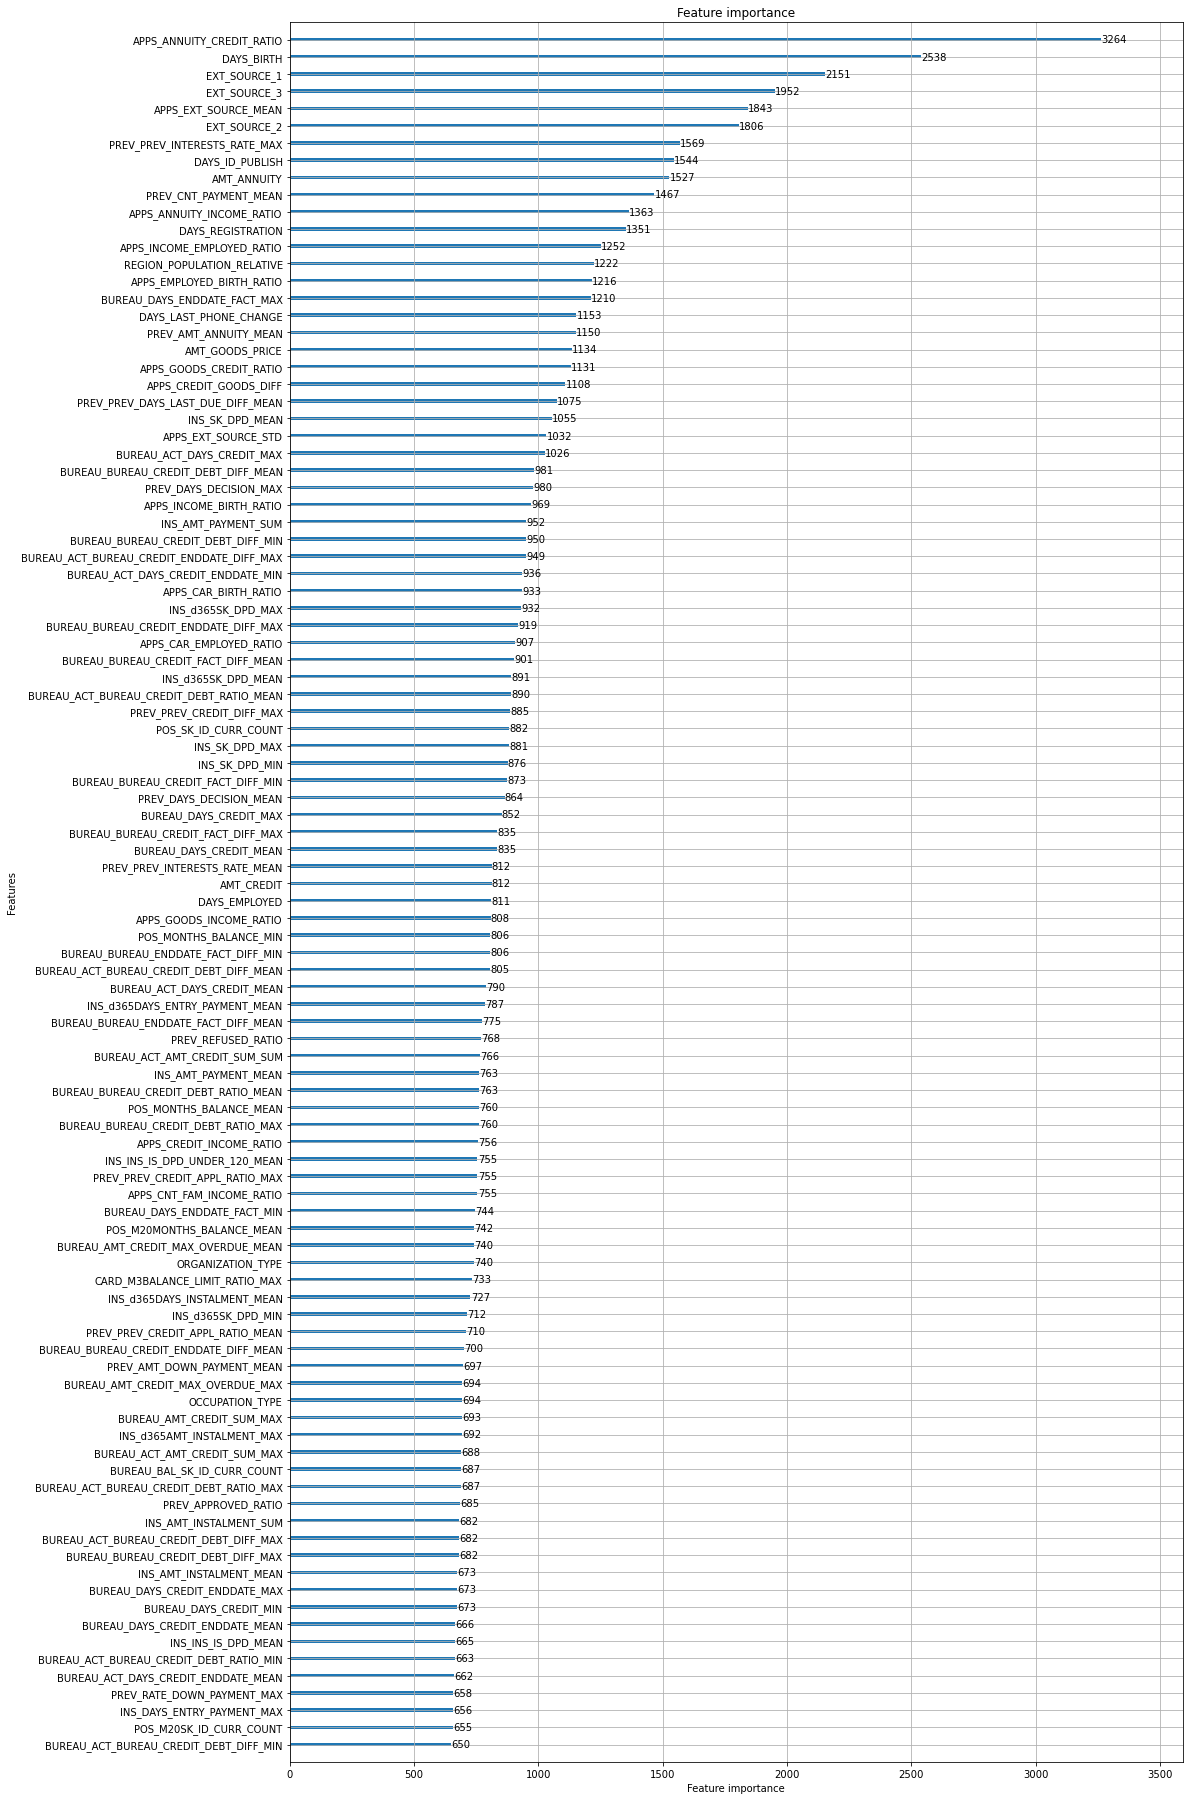

In [12]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)